In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
import datetime
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import xgboost as xgb
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb


In [2]:
!apt-get install default-jre
!java -version
!pip install h2o


Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
     |████████████████████████████████| 164.6MB 85kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.4-py2.py3-none-any.whl size=164670979 sha256=6126d1ef418e8c6355192eda8332a64f61076f2f0b0e7e45f358e0bfe844a7ad
  Stored in directory: /root/.cache/pip/wheels/65/f4/0d/c9bb958d70c2e015c968cb91cbd7f1b486933056d422337d75
Successfully built h2o


In [3]:
from google.colab import files
uploaded = files.upload()

Saving train.tsv to train.tsv


In [4]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['train.tsv']),sep='\t')


In [5]:
from google.colab import files
uploaded = files.upload()

Saving test.tsv to test.tsv


In [6]:
df_test = pd.read_csv(io.BytesIO(uploaded['test.tsv']),sep='\t')


In [7]:

df_train['label'].value_counts()

1    3796
0    3599
Name: label, dtype: int64

In [8]:
X = df_train.drop(columns=['label'])
y = df_train['label']

In [9]:

drop_feat=["urlid"]
numeric_features =["alchemy_category_score","avglinksize","commonlinkratio_1","commonlinkratio_2","commonlinkratio_3","commonlinkratio_4","linkwordscore","non_markup_alphanum_characters","numberOfLinks","numwords_in_url","parametrizedLinkRatio","spelling_errors_ratio"]
categorical_features =["alchemy_category","is_news","lengthyLinkDomain","news_front_page"]


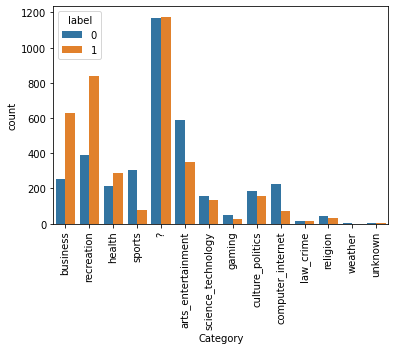

In [10]:
sns.countplot(x=df_train['alchemy_category'],hue=df_train['label']);
plt.xlabel('Category');
plt.xticks(rotation=90);

In [11]:
columns =  [i for i in df_train.columns if i not in [ 'url','urlid', 'boilerplate', 'label']]

In [12]:
enc = OneHotEncoder()
for i in categorical_features:
    S = set(df_train[i]) - set(df_test[i])
    print(S)
    for k in S:
        df_train[i] = df_train[i].replace([k,'<', np.nan], 'NaN')
        df_test[i] = df_test[i].replace([k,'<', np.nan], 'NaN')
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    
        

{'unknown', 'weather'}
set()
set()
set()


In [13]:

df_train.isna().sum()

url                               0
urlid                             0
boilerplate                       0
alchemy_category                  0
alchemy_category_score            0
avglinksize                       0
commonlinkratio_1                 0
commonlinkratio_2                 0
commonlinkratio_3                 0
commonlinkratio_4                 0
compression_ratio                 0
embed_ratio                       0
framebased                        0
frameTagRatio                     0
hasDomainLink                     0
html_ratio                        0
image_ratio                       0
is_news                           0
lengthyLinkDomain                 0
linkwordscore                     0
news_front_page                   0
non_markup_alphanum_characters    0
numberOfLinks                     0
numwords_in_url                   0
parametrizedLinkRatio             0
spelling_errors_ratio             0
label                             0
dtype: int64

In [14]:
df_train

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7390,http://techcrunch.com/2010/09/08/kno-raises-46...,8958,"{""title"":""Kno Raises 46 Million More To Build ...",computer_internet,0.651067,3.010526,0.474747,0.222222,0.191919,0.191919,0.474273,0.0,0,0.177043,0,0.256669,0.048780,1,1,38,0,2219,99,11,0.040404,0.071429,0
7391,http://www.uncoached.com/category/why-i-miss-c...,8895,"{""title"":""Why I Miss College "",""body"":""Mar 30 ...",culture_politics,0.14192,2.208054,0.483333,0.246667,0.036667,0.026667,0.558184,0.0,0,0.057377,0,0.218014,0.225962,1,1,34,0,5672,300,4,0.020000,0.109453,0
7392,http://eatthis.menshealth.com/slide/sweet-pota...,1191,"{""title"":""Sweet Potatoes Eat This Not That i'...",recreation,0.196273,2.000000,0.315789,0.171053,0.105263,0.052632,0.692529,0.0,0,0.124122,0,0.248388,0.464286,?,1,43,0,848,76,5,0.434211,0.117647,1
7393,http://naturallyella.com/,5612,"{""title"":""Naturally Ella "",""body"":"" "",""url"":""n...",arts_entertainment,0.617876,1.026316,0.210526,0.052632,0.000000,0.000000,21.000000,-1.0,0,0.097778,0,0.256070,-1.000000,1,0,37,1,386,38,0,0.026316,0.333333,1


In [15]:
df_train['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_train['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_train['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_train['boilerplate']=df_train['boilerplate'].str.lower()


df_test['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_test['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_test['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_test['boilerplate']=df_test['boilerplate'].str.lower()


In [16]:
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state=111)

In [17]:
#stemmer = PorterStemmer()
stemmer = nltk.stem.SnowballStemmer('english')

In [18]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
def tokenize(text):
    tokens = [word for word in nltk.word_tokenize(text)]
    tokens = map(str.lower, tokens)
    stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
    return stems

In [20]:
nltk.download('punkt')
  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.boilerplate)

In [22]:
vectorizer_tf.get_feature_names()

['!',
 '#',
 '&',
 '& #',
 "'' ,",
 "'' ``",
 "'s",
 '(',
 ')',
 ', food',
 ', recip',
 '-',
 '.',
 '. ``',
 '...',
 '0',
 '00',
 '000',
 '01',
 '02',
 '05',
 '06',
 '07',
 '08',
 '09',
 '1',
 '1 1',
 '1 2',
 '1 3',
 '1 4',
 '1 cup',
 '10',
 '10 minut',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '15 minut',
 '16',
 '17',
 '18',
 '19',
 '2',
 '2 3',
 '2 cup',
 '2 tablespoon',
 '2 teaspoon',
 '20',
 '20 minut',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '3 4',
 '3 cup',
 '30',
 '30 minut',
 '350',
 '4',
 '4 cup',
 '40',
 '45',
 '5',
 '5 minut',
 '50',
 '6',
 '7',
 '8',
 '9',
 ';',
 '?',
 'abl',
 'accord',
 'acid',
 'across',
 'activ',
 'actual',
 'ad',
 'add',
 'addit',
 'age',
 'ago',
 'air',
 'alcohol',
 'allow',
 'almond',
 'almost',
 'along',
 'alreadi',
 'also',
 'altern',
 'although',
 'alway',
 'amaz',
 'american',
 'amount',
 'anim',
 'anoth',
 'anyth',
 'app',
 'appear',
 'appl',
 'april',

In [23]:
test_vectors = vectorizer_tf.transform(X_test.boilerplate)

In [24]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train["label"].reset_index(drop=True)], axis=1)
train_df

,!,#,&,& #,"'' ,",'' ``,'s,(,),", food",", recip",-,.,. ``,...,0,00,000,01,02,05,06,07,08,09,1,1 1,1 2,1 3,1 4,1 cup,10,10 minut,100,11,12,13,14,15,15 minut,...,walk,want,warm,watch,water,way,wear,web,websit,week,weight,well,went,whether,whip,whisk,white,whole,width,win,wine,without,woman,women,wonder,word,work,workout,world,would,wrap,write,www,www damascus,year,year old,yes,yet,york,label
0,0.0,0.0,0.000000,0.0,0.023162,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055893,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.07219,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
1,0.0,0.0,0.000000,0.0,0.006075,0.0,0.0,0.000000,0.0,0.0,0.000000,0.014001,0.014860,0.012888,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.138142,0.000000,0.063089,0.000000,0.030542,0.015922,0.021422,0.034148,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.010890,0.000000,0.015050,0.012816,0.021147,0.0,0.00000,0.000000,0.000000,0.0,0.020549,0.000000,0.017122,0.018437,0.016738,0.040961,0.028339,0.021089,0.0,0.000000,0.013597,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.069903,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
2,0.0,0.0,0.000000,0.0,0.042022,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.102797,0.089152,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1
3,0.0,0.0,0.000000,0.0,0.030395,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.037177,0.000000,0.000000,0.082605,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.172800,0.000000,0.000000,0.000000,0.000000,0.000000,0.053593,0.000000,0.000000,0.000000,0.260864,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.051409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105517,0.0,0.000000,0.068034,0.0,0.0,0.0,0.000000,0.000000,0.0,0.062686,0.00000,0.000000,0.088585,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1
4,0.0,0.0,0.000000,0.0,0.015386,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.018820,0.000000,0.000000,0.000000,0.055503,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033013,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.026024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.055784,0.000000,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5911,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.055824,0.012309,0.009065,0.013537,0.054854,0.000000,0.000000,0.000000,0.012033,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.015647,0.000000,0.021624,0.009207,0.022788,0.0,0.00000,0.000000,0.009279,0.0,0.000000,0.025243,0.0

In [25]:
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['label'].reset_index(drop=True)], axis=1)
test_df


,!,#,&,& #,"'' ,",'' ``,'s,(,),", food",", recip",-,.,. ``,...,0,00,000,01,02,05,06,07,08,09,1,1 1,1 2,1 3,1 4,1 cup,10,10 minut,100,11,12,13,14,15,15 minut,...,walk,want,warm,watch,water,way,wear,web,websit,week,weight,well,went,whether,whip,whisk,white,whole,width,win,wine,without,woman,women,wonder,word,work,workout,world,would,wrap,write,www,www damascus,year,year old,yes,yet,york,label
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.067146,0.0,0.0,0.0,0.030023,0.000000,0.000000,0.000000,0.000000,0.055367,0.037246,0.0,0.0,0.000000,0.0,0.057044,0.0,0.000000,0.000000,...,0.0,0.000000,0.052963,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.038605,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,1
1,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.147987,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.119357,0.0,0.182520,0.00000,0.0,0
2,0.0,0.000000,0.000000,0.000000,0.055720,0.0,0.0,0.0,0.0,0.0,0.00000,0.064213,0.102230,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.069853,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.118478,0.0,0.000000,0.080574,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.049901,0.0,0.057458,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0
3,0.0,0.037258,0.029107,0.038635,0.023724,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.029018,0.0,0.029757,0.0,0.0,0.0,0.0,0.037592,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020915,0.0,0.0,0.000000,0.0,0.000000,0.0,0.025980,0.034818,...,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.060190,0.000000,0.0,0.000000,0.0000,0.026662,0.000000,0.0,0.000000,0.000000,0.053103,0.0,0.0,0.000000,0.000000,0.063740,0.0,0.000000,0.086716,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.03077,0.0,1
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.107764,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.081808,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0000,0.000000,0.059008,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.060722,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,0.0,0.000000,0.000000,0.000000,0.008892,0.0,0.0,0.0,0.0,0.0,0.02539,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.037913,0.025080,0.018469,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.038948,0.000000,...,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.015039,0.000000,0.0,0.026987,0.0735,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.023320,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016119,0.0,0.000000,0.00000,0.0,1
1475,0.0,0.000000,0.000000,0.000000,0.003205,0.

In [26]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1ocnnvrx
  JVM stdout: /tmp/tmp1ocnnvrx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1ocnnvrx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_cv5n6x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [27]:

from h2o.automl import H2OAutoML
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [28]:
h2o_train_df.types

{'!': 'real',
 '#': 'real',
 '&': 'real',
 '& #': 'real',
 "'' ,": 'real',
 "'' ``": 'real',
 "'s": 'real',
 '(': 'real',
 ')': 'real',
 ', food': 'real',
 ', recip': 'real',
 '-': 'real',
 '.': 'real',
 '. ``': 'real',
 '...': 'real',
 '0': 'real',
 '00': 'real',
 '000': 'real',
 '01': 'real',
 '02': 'real',
 '05': 'real',
 '06': 'real',
 '07': 'real',
 '08': 'real',
 '09': 'real',
 '1': 'real',
 '1 1': 'real',
 '1 2': 'real',
 '1 3': 'real',
 '1 4': 'real',
 '1 cup': 'real',
 '10': 'real',
 '10 minut': 'real',
 '100': 'real',
 '11': 'real',
 '12': 'real',
 '13': 'real',
 '14': 'real',
 '15': 'real',
 '15 minut': 'real',
 '16': 'real',
 '17': 'real',
 '18': 'real',
 '19': 'real',
 '2': 'real',
 '2 3': 'real',
 '2 cup': 'real',
 '2 tablespoon': 'real',
 '2 teaspoon': 'real',
 '20': 'real',
 '20 minut': 'real',
 '2006': 'real',
 '2007': 'real',
 '2008': 'real',
 '2009': 'real',
 '2010': 'real',
 '2011': 'real',
 '2012': 'real',
 '21': 'real',
 '22': 'real',
 '23': 'real',
 '24': 'real',

In [29]:
h2o_train_df['label'] = h2o_train_df['label'].asfactor()
h2o_test_df['label'] = h2o_test_df['label'].asfactor()

In [30]:
aml = H2OAutoML(max_models = 40, seed = 10, exclude_algos = ["StackedEnsemble"], verbosity="info", nfolds=0, balance_classes=True, max_after_balance_size=0.3)

In [31]:
x=vectorizer_tf.get_feature_names()
y='label'

In [32]:
aml.train(x = x, y = y, training_frame = h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
08:04:13.180: Project: AutoML_20210217_80413176
08:04:13.181: Cross-validation disabled by user: no fold column nor nfolds > 1.
08:04:13.184: Setting stopping tolerance adaptively based on the training frame: 0.013001274187308594
08:04:13.184: Build control seed: 10
08:04:13.184: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
08:04:14.876: training frame: Frame key: automl_training_py_1_sid_a2e2    cols: 1001    rows: 5325  chunks: 8    size: 7302214  checksum: -5095414567146852144
08:04:14.880: validation frame: Frame key: py_2_sid_a2e2    cols: 1001    rows: 1479  chunks: 2    size: 1903138  checksum: -8095428777167740076
08:04:14.993: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_a2e2    cols: 1001    rows: 591  chunks: 8    size: 1356635  checksum: 5163347637236007808
08:04:14.993: blending frame: NULL
08:04:14.993: response column

In [33]:
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_grid__1_AutoML_20210217_080413_model_4,0.880685,0.439064,0.901306,0.191616,0.372441,0.138712
XGBoost_3_AutoML_20210217_080413,0.880363,0.431977,0.890022,0.189803,0.369333,0.136407
XGBoost_grid__1_AutoML_20210217_080413_model_12,0.879956,0.434407,0.886134,0.195723,0.371854,0.138275
XGBoost_grid__1_AutoML_20210217_080413_model_9,0.879721,0.431795,0.895723,0.180252,0.368262,0.135617
GBM_1_AutoML_20210217_080413,0.879646,0.442607,0.889809,0.217165,0.377198,0.142279
GLM_1_AutoML_20210217_080413,0.877398,0.43632,0.895091,0.201786,0.374653,0.140365
GBM_3_AutoML_20210217_080413,0.8773,0.434086,0.888887,0.188272,0.372388,0.138673
GBM_grid__1_AutoML_20210217_080413_model_2,0.877208,0.435401,0.89145,0.190566,0.372226,0.138552
GBM_5_AutoML_20210217_080413,0.87695,0.433211,0.894582,0.200117,0.371666,0.138135
GBM_grid__1_AutoML_20210217_080413_model_3,0.87636,0.439535,0.889481,0.218645,0.376856,0.14202


In [34]:
pred=aml.leader.predict(h2o_test_df)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [35]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.15120305421008381
RMSE: 0.38884836917503435
LogLoss: 0.47769143017210763
Mean Per-Class Error: 0.1977910800873094
AUC: 0.856393653956023
AUCPR: 0.8751343497534548
Gini: 0.7127873079120459

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4723234474658966: 


,,0,1,Error,Rate
0,0,582.0,130.0,0.1826,(130.0/712.0)
1,1,168.0,599.0,0.219,(168.0/767.0)
2,Total,750.0,729.0,0.2015,(298.0/1479.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.472323,0.800802,194.0
1,max f2,0.093930,0.853575,354.0
2,max f0point5,0.689560,0.837795,135.0
3,max accuracy,0.617179,0.799189,152.0
4,max precision,0.998485,1.000000,0.0
5,max recall,0.009705,1.000000,398.0
6,max specificity,0.998485,1.000000,0.0
7,max absolute_mcc,0.617179,0.610004,152.0
8,max min_per_class_accuracy,0.446883,0.791395,203.0
9,max mean_per_class_accuracy,0.617179,0.802209,152.0



Gains/Lift Table: Avg response rate: 51.86 %, avg score: 52.81 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010142,0.995680,1.799739,1.799739,0.933333,0.996668,0.933333,0.996668,0.018253,0.018253,79.973924,79.973924,0.016848
1,2,0.020284,0.994180,1.928292,1.864016,1.000000,0.995016,0.966667,0.995842,0.019557,0.037810,92.829205,86.401565,0.036405
2,3,0.030426,0.992543,1.799739,1.842590,0.933333,0.993343,0.955556,0.995009,0.018253,0.056063,79.973924,84.259018,0.053254
3,4,0.040568,0.991389,1.799739,1.831877,0.933333,0.991971,0.950000,0.994249,0.018253,0.074316,79.973924,83.187744,0.070102
4,5,0.050034,0.989836,1.928292,1.850118,1.000000,0.990796,0.959459,0.993596,0.018253,0.092568,92.829205,85.011805,0.088355
5,6,0.100068,0.981733,1.850118,1.850118,0.959459,0.985596,0.959459,0.989596,0.092568,0.185137,85.011805,85.011805,0.176710
6,7,0.150101,0.970682,1.850118,1.850118,0.959459,0.976362,0.959459,0.985185,0.092568,0.277705,85.011805,85.011805,0.265065
7,8,0.200135,0.954795,1.824060,1.843604,0.945946,0.963177,0.956081,0.979683,0.091265,0.368970,82.406004,84.360354,0.350712
8,9,0.300203,0.903230,1.641654,1.776287,0.851351,0.931150,0.921171,0.963505,0.164276,0.533246,64.165404,77.628704,0.484089
9,10,0.400270,0.715421,1.485306,1.703542,0.770270,0.823947,0.883446,0.928616,0.148631,0.681877,48.530604,70.354179,0.584967


In [36]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [37]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20210217_080413_model_4


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.05888895058925033
RMSE: 0.2426704567705973
LogLoss: 0.2155942085965499
Mean Per-Class Error: 0.06502039945330473
AUC: 0.9842760212287545
AUCPR: 0.9864281714484938
Gini: 0.9685520424575089

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4329746152673449: 


,,0,1,Error,Rate
0,0,2464.0,140.0,0.0538,(140.0/2604.0)
1,1,209.0,2512.0,0.0768,(209.0/2721.0)
2,Total,2673.0,2652.0,0.0655,(349.0/5325.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.432975,0.935046,204.0
1,max f2,0.299065,0.949132,253.0
2,max f0point5,0.577640,0.954817,163.0
3,max accuracy,0.439124,0.934648,202.0
4,max precision,0.997672,1.000000,0.0
5,max recall,0.101985,1.000000,342.0
6,max specificity,0.997672,1.000000,0.0
7,max absolute_mcc,0.439124,0.869803,202.0
8,max min_per_class_accuracy,0.418444,0.931644,210.0
9,max mean_per_class_accuracy,0.439124,0.934980,202.0



Gains/Lift Table: Avg response rate: 51.10 %, avg score: 51.11 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010141,0.996545,1.957001,1.957001,1.000000,0.997313,1.000000,0.997313,0.019846,0.019846,95.700110,95.700110,0.019846
1,2,0.020094,0.994767,1.957001,1.957001,1.000000,0.995670,1.000000,0.996499,0.019478,0.039324,95.700110,95.700110,0.039324
2,3,0.030047,0.993236,1.957001,1.957001,1.000000,0.993954,1.000000,0.995656,0.019478,0.058802,95.700110,95.700110,0.058802
3,4,0.040000,0.992017,1.957001,1.957001,1.000000,0.992602,1.000000,0.994896,0.019478,0.078280,95.700110,95.700110,0.078280
4,5,0.050141,0.990682,1.957001,1.957001,1.000000,0.991320,1.000000,0.994173,0.019846,0.098126,95.700110,95.700110,0.098126
5,6,0.100094,0.983621,1.957001,1.957001,1.000000,0.987247,1.000000,0.990716,0.097758,0.195884,95.700110,95.700110,0.195884
6,7,0.150047,0.974219,1.957001,1.957001,1.000000,0.979212,1.000000,0.986886,0.097758,0.293642,95.700110,95.700110,0.293642
7,8,0.200000,0.960892,1.957001,1.957001,1.000000,0.968233,1.000000,0.982227,0.097758,0.391400,95.700110,95.700110,0.391400
8,9,0.300094,0.903216,1.953329,1.955776,0.998124,0.936012,0.999374,0.966812,0.195516,0.586917,95.332943,95.577645,0.586533
9,10,0.400000,0.720058,1.927573,1.948732,0.984962,0.831161,0.995775,0.932931,0.192576,0.779493,92.757251,94.873208,0.776037




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.15120305445092885
RMSE: 0.38884836948472457
LogLoss: 0.4776914308057654
Mean Per-Class Error: 0.1977910800873094
AUC: 0.856393653956023
AUCPR: 0.8751343497534548
Gini: 0.7127873079120459

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4723234474658966: 


,,0,1,Error,Rate
0,0,582.0,130.0,0.1826,(130.0/712.0)
1,1,168.0,599.0,0.219,(168.0/767.0)
2,Total,750.0,729.0,0.2015,(298.0/1479.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.472323,0.800802,194.0
1,max f2,0.093930,0.853575,354.0
2,max f0point5,0.689560,0.837795,135.0
3,max accuracy,0.617179,0.799189,152.0
4,max precision,0.998485,1.000000,0.0
5,max recall,0.009705,1.000000,398.0
6,max specificity,0.998485,1.000000,0.0
7,max absolute_mcc,0.617179,0.610004,152.0
8,max min_per_class_accuracy,0.446883,0.791395,203.0
9,max mean_per_class_accuracy,0.617179,0.802209,152.0



Gains/Lift Table: Avg response rate: 51.86 %, avg score: 52.81 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010142,0.995680,1.799739,1.799739,0.933333,0.996668,0.933333,0.996668,0.018253,0.018253,79.973924,79.973924,0.016848
1,2,0.020284,0.994180,1.928292,1.864016,1.000000,0.995016,0.966667,0.995842,0.019557,0.037810,92.829205,86.401565,0.036405
2,3,0.030426,0.992543,1.799739,1.842590,0.933333,0.993343,0.955556,0.995009,0.018253,0.056063,79.973924,84.259018,0.053254
3,4,0.040568,0.991389,1.799739,1.831877,0.933333,0.991971,0.950000,0.994249,0.018253,0.074316,79.973924,83.187744,0.070102
4,5,0.050034,0.989836,1.928292,1.850118,1.000000,0.990796,0.959459,0.993596,0.018253,0.092568,92.829205,85.011805,0.088355
5,6,0.100068,0.981733,1.850118,1.850118,0.959459,0.985596,0.959459,0.989596,0.092568,0.185137,85.011805,85.011805,0.176710
6,7,0.150101,0.970682,1.850118,1.850118,0.959459,0.976362,0.959459,0.985185,0.092568,0.277705,85.011805,85.011805,0.265065
7,8,0.200135,0.954795,1.824060,1.843604,0.945946,0.963177,0.956081,0.979683,0.091265,0.368970,82.406004,84.360354,0.350712
8,9,0.300203,0.903230,1.641654,1.776287,0.851351,0.931150,0.921171,0.963505,0.164276,0.533246,64.165404,77.628704,0.484089
9,10,0.400270,0.715421,1.485306,1.703542,0.770270,0.823947,0.883446,0.928616,0.148631,0.681877,48.530604,70.354179,0.584967




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-02-17 08:07:21,21.639 sec,0.0,0.500000,0.693147,0.500000,0.510986,1.000000,0.489014,0.500000,0.693147,0.500000,0.518594,1.000000,0.481406
1,,2021-02-17 08:07:23,23.124 sec,5.0,0.343837,0.394339,0.931981,0.942687,1.957001,0.148732,0.392080,0.478393,0.856189,0.868597,1.799739,0.209601
2,,2021-02-17 08:07:24,24.069 sec,10.0,0.308510,0.321783,0.951388,0.959173,1.957001,0.125258,0.383152,0.457218,0.863562,0.876475,1.799739,0.198107
3,,2021-02-17 08:07:25,25.415 sec,15.0,0.288184,0.284705,0.963623,0.968983,1.957001,0.105728,0.383586,0.459106,0.862683,0.878848,1.928292,0.208249
4,,2021-02-17 08:07:26,26.407 sec,20.0,0.271443,0.257357,0.972129,0.976237,1.957001,0.086197,0.384371,0.462018,0.862442,0.882225,1.928292,0.201487
5,,2021-02-17 08:07:27,27.391 sec,25.0,0.256461,0.235077,0.978545,0.981773,1.957001,0.075493,0.385442,0.467808,0.860769,0.880813,1.799739,0.198783
6,,2021-02-17 08:07:28,28.409 sec,30.0,0.242670,0.215594,0.984276,0.986428,1.957001,0.065540,0.388848,0.477691,0.856394,0.875134,1.799739,0.201487



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,recip,2370.912354,1.000000,0.257208
1,cook,334.081696,0.140908,0.036243
2,food,206.682541,0.087174,0.022422
3,"'' ,",165.263535,0.069705,0.017929
4,salt,163.256470,0.068858,0.017711
5,make,162.729736,0.068636,0.017654
6,bake,147.736816,0.062312,0.016027
7,.,111.515488,0.047035,0.012098
8,exercis,104.254936,0.043972,0.011310
9,eat,101.041412,0.042617,0.010961



See the whole table with table.as_data_frame()


In [38]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.01,
  'booster': 'dart',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.9,
  'eta': 0.3,
  'gamma': 0.0,
  'grow_policy': 'depthwise',
  'lambda': 0.1,
  'max_delta_step': 0.0,
  'max_depth': 15,
  'min_child_weight': 5.0,
  'normalize_type': 'tree',
  'nround': 10000,
  'nthread': 2,
  'objective': 'binary:logistic',
  'one_drop': '0',
  'rate_drop': 0.0,
  'sample_type': 'uniform',
  'seed': 26,
  'silent': True,
  'skip_drop': 0.0,
  'subsample': 0.8,
  'tree_method': 'exact'},
 10000)

In [39]:
from sklearn.model_selection import GridSearchCV
parameters={"learning_rate":[0.001,0.01,0.1,1],"n_estimators":[10,100,500,1000]}
clf=GridSearchCV(xgb.XGBClassifier(),parameters,cv=5)
clf.fit(train_vectors,X_train["label"])
clf.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

In [40]:

xgb_clf = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=15, objective='binary:logistic', random_state=10)

In [41]:
xgb_clf.fit(train_vectors, X_train['label'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
predictions = xgb_clf.predict(test_vectors)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(X_test['label'], predictions)
print(cm)

[[571 141]
 [181 586]]


In [44]:
predictions.shape

(1479,)

In [45]:
X_test['label'].shape

(1479,)

In [46]:
test_vectors.shape

(1479, 1000)

In [47]:
print('classification_report :\n',classification_report(X_test['label'], predictions))

classification_report :
               precision    recall  f1-score   support

           0       0.76      0.80      0.78       712
           1       0.81      0.76      0.78       767

    accuracy                           0.78      1479
   macro avg       0.78      0.78      0.78      1479
weighted avg       0.78      0.78      0.78      1479



accuracy_score 0.7822853279242732
roc_auc_score= 0.7829909687532045


AxesSubplot(0.125,0.808774;0.62x0.0712264)


No handles with labels found to put in legend.


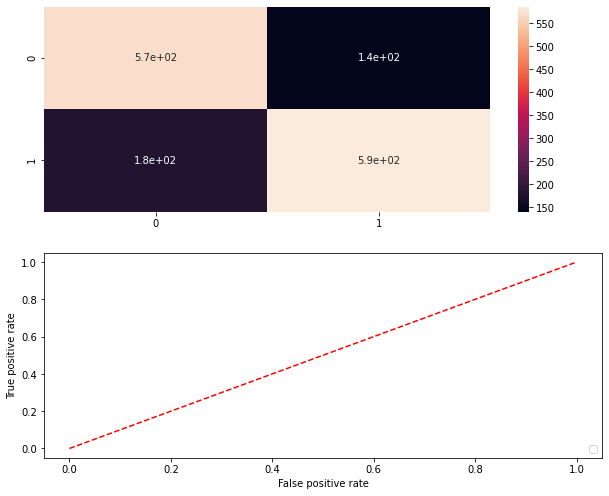

In [54]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
model=xgb_clf
score=[]
roc_score=[]
AS=accuracy_score(X_test['label'], predictions)
print("accuracy_score",AS)
score.append(AS*100)
false_positive_rate,true_positive_rate,threshold=roc_curve(X_test['label'], predictions)
roc_auc=auc(false_positive_rate,true_positive_rate)
print("roc_auc_score=",roc_auc)
roc_score.append(roc_auc*100)
print('\n')
plt.figure(figsize=(10,40))
plt.subplot(911)
print(sns.heatmap(cm,annot=True))
plt.subplot(912)
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
print('\n\n')

In [48]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
test = vectorizer_tf.fit_transform(df_test.boilerplate)

In [49]:
final_predictions=xgb_clf.predict(test)
df_test['label']=final_predictions

df_test.to_csv('submission.csv',columns=['urlid','label'],index=False)

In [56]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [57]:
!cp submission.csv "drive/My Drive/"